Zhang Chao, 2025/04/03<br>
Contribution of environmental factors to the cooling trends<br>

In [1]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import geopandas as gpd
import statsmodels.api as sm
import regionmask
from scipy.stats import linregress
import sys
import os
sys.path.append('/home/climate/chaoz/code/utils/')
from plot_utils import plot_settings

In [2]:
os.chdir('/home/climate/chaoz/project/03Irr_Ts_CN/processed/')
BGC = xr.open_dataset('bgc_terraclimate_Yr_CN_1km_2001_2020.nc')
dLSTd = xr.open_dataset('delta_LSTday_Yr_CN_2001_2020.nc')
dLSTn = xr.open_dataset('delta_LSTnight_Yr_CN_2001_2020.nc')
dEVI  = xr.open_dataset('delta_EVI_Yr_CN_2001_2020.nc')

shp_cn = gpd.read_file('../shapefile/ChinaAll.shp')
shp_nanhai = gpd.read_file('../shapefile/Nanhai.shp')
shp_climzone = gpd.read_file('../shapefile/ClimateZone_3.shp')

In [3]:
def stats_regionmean(ds,varname,shp):
    """Calculate the national and regional mean values

    Args:
        ds (xarray dataset): time-series dataset
        varname (str): the variable name in the xarray dataset
        shp (geo dataframe): shapefile loaded by geopandas.read_file()

    Returns:
        numpy.dataframe: time-series annual means for different regions
    """
    # Calculate the national mean values
    stat_cn = ds.mean(dim=('lat','lon'))[varname].values
    
    mask_region = regionmask.mask_geopandas(shp,ds.lon,ds.lat)
    stat_region = ds.groupby(mask_region).mean().to_dataframe().reset_index()
    
    mask_mapping = {0.0:'Humid', 1.0:'Arid', 2.0:'Semi'}
    stat_region['mask'] = stat_region['mask'].replace(mask_mapping)
    
    # Rearrange the dataframe by the different masks (regions)
    pivoted_df = stat_region.pivot_table(index='time', columns='mask', values=varname).reset_index()
    # Append the national mean values as a column 'China'
    pivoted_df['China'] = stat_cn
    
    # Re-order the columns
    pivoted_df = pivoted_df[['time','China','Arid','Semi','Humid']]
    
    return pivoted_df


def get_contribution(dlst,iwu,pr,ta,sr,ws,devi,region):
    df = pd.DataFrame({
                     'dLst':dlst[region][2:].to_list(),
                     'dIwu':iwu[region].to_list(),
                     'Pr':pr[region][2:].to_list(),
                     'Ta':ta[region][2:].to_list(),
                     'Sr':sr[region][2:].to_list(),
                     'Ws':ws[region][2:].to_list(),
                     'dEvi':devi[region][2:].to_list(),
                     })

    slopes = {col: linregress(range(len(df[col])), df[col]).slope for col in df.columns}
    
    vars_y = ['dLst']
    vars_x = ['dIwu','Pr','Ta','Sr','Ws','dEvi']
    
    x = sm.add_constant(df[vars_x])
    y = df[vars_y]
    model = sm.OLS(y, x)
    result = model.fit()
    result.params
    
    out_r = {'pval' : result.f_pvalue ,
    'r2'    :result.rsquared,
    'tr'    : slopes['dLst'],
    'tr2iwu': result.params.iloc[1] * slopes['dIwu'],
    'tr2evi': result.params.iloc[6] * slopes['dEvi'],
    'tr2bc' : result.params.iloc[2] * slopes['Pr']  
            + result.params.iloc[3] * slopes['Ta']  
            + result.params.iloc[4] * slopes['Sr']  
            + result.params.iloc[5] * slopes['Ws']    
    }
    
    return out_r

In [4]:
'''
The regional statistics are written to csv files, loading them
again because the calculation process is time-intensive.
'''
# df_pr = stats_regionmean(BGC,'pr',shp_climzone)
# df_ta = stats_regionmean(BGC,'ta',shp_climzone)
# df_sr = stats_regionmean(BGC,'sr',shp_climzone)
# df_ws = stats_regionmean(BGC,'ws',shp_climzone)
# df_dEVI = stats_regionmean(dEVI,'EVI',shp_climzone)
# df_pr.to_csv('regionmean_pr.csv')
# df_sr.to_csv('regionmean_sr.csv')
# df_ta.to_csv('regionmean_ta.csv')
# df_ws.to_csv('regionmean_ws.csv')
# df_dEVI.to_csv('regionmean_dEVI.csv')

'\nThe regional statistics are written to csv files, loading them\nagain because the calculation process is time-intensive.\n'

In [5]:
df_dLSTday   = pd.read_csv('regionmean_dLSTday_Yr.csv')
df_dLSTnight = pd.read_csv('regionmean_dLSTnight_Yr.csv')
df_IWU       = pd.read_csv('regionmean_IWU_Yr.csv')
df_pr        = pd.read_csv('regionmean_pr.csv')
df_sr        = pd.read_csv('regionmean_sr.csv')
df_ta        = pd.read_csv('regionmean_ta.csv')
df_ws        = pd.read_csv('regionmean_ws.csv')
df_dEVI      = pd.read_csv('regionmean_dEVI.csv')

In [6]:
'''
Get the regional trend contributed by iwu, background climate, and evi
'''
regions=['China','Arid','Semi','Humid']
con_day = [get_contribution(df_dLSTday,df_IWU,df_pr,df_ta,df_sr,df_ws,df_dEVI,region) for region in regions]
df_con_day = pd.DataFrame(con_day)
df_con_day.index = regions
df_con_day = df_con_day.T

con_night = [get_contribution(df_dLSTnight,df_IWU,df_pr,df_ta,df_sr,df_ws,df_dEVI,region) for region in regions]
df_con_night = pd.DataFrame(con_night)
df_con_night.index = regions

df_con_night = df_con_night.T

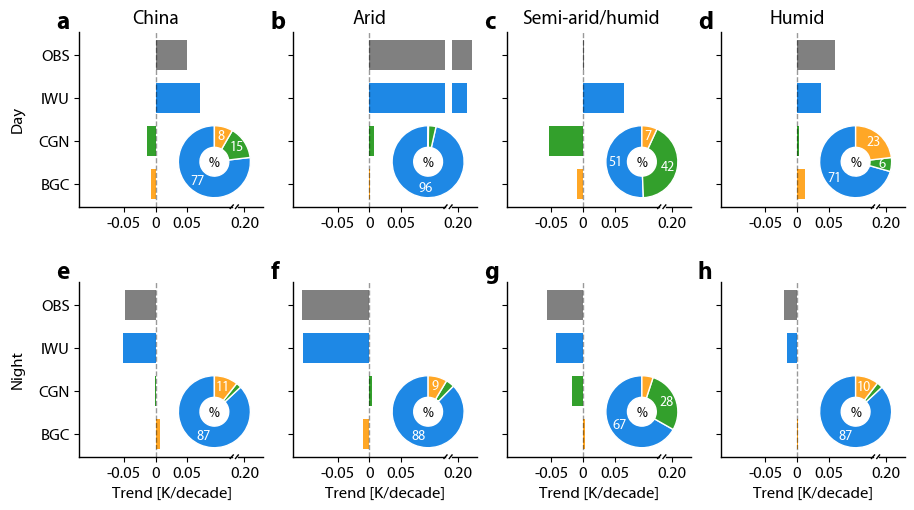

In [8]:
p1,p2=0.01,0.05
yticks = ['OBS','IWU','CGN', 'BGC']#,'Res'
# yticks = ['Observation','WSI', 'Crop greening','Background climate']#,'Res'

'''significance level'''
def getSigFlag(p):
    strSig = ''
    if p<p1:
        strSig = '**'
    elif p<p2:
        strSig = '*'
    else:
        strSig = ''
    return strSig


def DrawGraph(fig,pos,df,No,ylabelflag,xlabelflag,ylabel):
    ax = fig.add_axes(pos)
    pval = df.iloc[0]
    r2   = df.iloc[1]
    newdfc = df[2:] * 10
    
    yax = [4,3,2,1]
    ax.barh(y = yax,width=newdfc,height=0.8,color=colors)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim([-0.12,0.12])

    ax.text(-0.16,1.02,No,weight='bold',fontsize=16,transform = ax.transAxes)
    if ylabelflag == True:
        ax.set_yticks(yax,yticks)
        ax.set_ylabel(ylabel)
    else:
        ax.set_yticks(yax,['','','',''])
    if xlabelflag == True:
        ax.set_xlabel('$\Delta$LST trend [K/decade]',y=-0.1)
    ax.text(0.25, 1.05, 'R$^2$ = %.2f%s'%(r2,getSigFlag(pval))
             , transform=ax.transAxes)
    ax.axvline(x=0.0, c="k", alpha=0.4, ls="--", lw=1)


def DrawGraph_com(fig,pos,df,No,ylabelflag,xlabelflag,ylabel):
    # Define positions for the two sub-axes
    pos1 = [pos[0], pos[1], pos[2]*6/7, pos[3]]  # Upper part
    pos2 = [pos[0]+pos[2]*6/7+0.007, pos[1], pos[2]*1/7, pos[3]]  # Lower part
    pos3 = [pos[0]+0.10,pos[1],0.10,0.18]
    # Create two axes for the broken y-axis
    ax1, ax2 = fig.add_axes(pos1), fig.add_axes(pos2)
    ax3 = fig.add_axes(pos3)
    ax3.patch.set_alpha(0)

    pval = df.iloc[0]
    r2   = df.iloc[1]
    newdfc = df[2:] * 10
    
    yax = [4,3,2,1]
    ax1.barh(y = yax,width=newdfc,height=0.7,color=colors)
    ax2.barh(y = yax,width=newdfc,height=0.7,color=colors)

    ax1.axvline(x=0.0, c="k", alpha=0.4, ls="--", lw=1)
    # **Set Y-axis limits based on breaks**
    ax1.set_xlim([-0.12,0.12])  # Upper part
    ax2.set_xlim([0.19, 0.23])  # Lower part
    
    if ylabelflag == True:
        ax1.set_yticks(yax,yticks)
        ax1.set_ylabel(ylabel,labelpad=10)
    else:
        ax1.set_yticks(yax,['','','',''])
    
    ax2.set_yticks([])
    ax2.set_xticks([0.20],['0.20'])
    
    # Add diagonal break marks
    d = .01  # size of diagonal lines
    kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False, linewidth=1)
    ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right

    kwargs.update(transform=ax2.transAxes)
    ax2.plot((-10*d, +d), (-d, +d), **kwargs)  # top-left
    
    ax1.set_xticks([-0.05,0,0.05],[-0.05,0,0.05])
    ax1.text(-0.15,1.02,No,weight='bold',fontsize=18,transform = ax1.transAxes)
    
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    
    for spine in ax3.spines.values():
        spine.set_visible(True)

    def autopct_func(pct):
        return f'{pct:.0f}' if pct > 6 else ''
    
    total = abs(newdfc.iloc[1]) + abs(newdfc.iloc[2]) + abs(newdfc.iloc[3])
    newdfc2 = [abs(newdfc.iloc[1])/total,abs(newdfc.iloc[2])/total,abs(newdfc.iloc[3])/total]
    wedges, texts , autotexts= ax3.pie(newdfc2, colors=colors[1:], radius=1.0, startangle=90,
                        wedgeprops=dict(width=0.6, edgecolor='w'),
                        autopct=autopct_func,pctdistance=0.73)#'%1.0f'
    for autotext in autotexts:
        autotext.set_color('w')
        
    ax3.text(0.44, 0.45,'%', transform=ax3.transAxes)
    return ax1 # Return the two axes


colors = ['gray','#1E88E5','#33A02C','#FFA726']

fig = plt.figure(figsize=(9,5))
plot_settings()

x0,y0 = 0.08,0.09
xi,yi = 0.04,0.15
hx1,vx1 = (1-x0-3*xi-0.01)/4,0.35

pos11 = [x0+(hx1+xi)*0, y0+(vx1+yi)*1, hx1, vx1]
pos12 = [x0+(hx1+xi)*1, y0+(vx1+yi)*1, hx1, vx1]
pos13 = [x0+(hx1+xi)*2, y0+(vx1+yi)*1, hx1, vx1]
pos14 = [x0+(hx1+xi)*3, y0+(vx1+yi)*1, hx1, vx1]

pos21 = [x0+(hx1+xi)*0, y0+(vx1+yi)*0, hx1, vx1]
pos22 = [x0+(hx1+xi)*1, y0+(vx1+yi)*0, hx1, vx1]
pos23 = [x0+(hx1+xi)*2, y0+(vx1+yi)*0, hx1, vx1]
pos24 = [x0+(hx1+xi)*3, y0+(vx1+yi)*0, hx1, vx1]


ax11 = DrawGraph_com(fig, pos11,df_con_day['China']  ,'a',True , False, 'Day')
ax12 = DrawGraph_com(fig, pos12,df_con_day['Arid']   ,'b',False, False, '')
ax13 = DrawGraph_com(fig, pos13,df_con_day['Semi']   ,'c',False, False, '')
ax14 = DrawGraph_com(fig, pos14,df_con_day['Humid']  ,'d',False, False, '')
ax21 = DrawGraph_com(fig, pos21,df_con_night['China'],'e',True , False, 'Night')
ax22 = DrawGraph_com(fig, pos22,df_con_night['Arid'] ,'f',False, False, '')
ax23 = DrawGraph_com(fig, pos23,df_con_night['Semi'] ,'g',False, False, '')
ax24 = DrawGraph_com(fig, pos24,df_con_night['Humid'],'h',False, False, '')

ax11.set_title('China')
ax12.set_title('Arid')
ax13.set_title('Semi-arid/humid',loc='right')
ax14.set_title('Humid')

ax21.set_xlabel('Trend [K/decade]',loc='right')
ax22.set_xlabel('Trend [K/decade]',loc='right')
ax23.set_xlabel('Trend [K/decade]',loc='right')
ax24.set_xlabel('Trend [K/decade]',loc='right')

# plt.savefig('../figures/Figure_04.png',dpi=300)
plt.savefig('../figures/Figure_04.pdf')